In [1]:
import sys
print(sys.version)
sys.path

3.10.12 (main, Jul  5 2023, 15:34:07) [Clang 14.0.6 ]


['/Users/vatsal/SSDCopy/Projects/LinearRegressionBasic02/notebooks',
 '/Users/vatsal/SSDCopy/Projects',
 '/Users/vatsal/miniconda/envs/Python310/lib/python310.zip',
 '/Users/vatsal/miniconda/envs/Python310/lib/python3.10',
 '/Users/vatsal/miniconda/envs/Python310/lib/python3.10/lib-dynload',
 '',
 '/Users/vatsal/miniconda/envs/Python310/lib/python3.10/site-packages']

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Project Description
##### The data is about Soccer Players and we need to predict the score based on the provided data.
###### This Project is to revise/practice the basics of Multi Linear Regression and implementation using scikit-learn, scipy, matplotlib/seaborn and obviously Python. Python Version here is 3.10.12 as seen above


#### Import Packages

In [3]:
# Pandas and NumPy
import pandas as pd
import numpy as np
# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
# Scipy
from scipy import stats
import scipy
# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, max_error, median_absolute_error


## Read the Soccer dataset

In [4]:
soccer_url = "../data/EPL_Soccer_MLR_LR.csv"
soccer_df = pd.read_csv(soccer_url)

In [5]:
soccer_df.columns

Index(['PlayerName', 'Club', 'DistanceCovered(InKms)', 'Goals',
       'MinutestoGoalRatio', 'ShotsPerGame', 'AgentCharges', 'BMI', 'Cost',
       'PreviousClubCost', 'Height', 'Weight', 'Score'],
      dtype='object')

In [6]:
soccer_df.shape

(202, 13)

###### 202 Rows and 13 Columns

## EDA

In [8]:
soccer_df.describe(include="all")

,PlayerName,Club,DistanceCovered(InKms),Goals,MinutestoGoalRatio,ShotsPerGame,AgentCharges,BMI,Cost,PreviousClubCost,Height,Weight,Score
count,202,202,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
unique,198,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,"Rogers, Mr. William John",CHE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.718614,7.108663,43.091584,14.566337,76.876238,22.955891,69.021782,64.873713,180.103960,75.008168,13.507426
std,NaN,NaN,0.457976,1.800549,3.662989,1.362451,47.501239,2.863933,32.565333,13.070197,9.734494,13.925574,6.189826
min,NaN,NaN,3.800000,3.300000,35.900000,11.600000,8.000000,16.750000,28.000000,34.360000,148.900000,37.800000,5.630000
25%,NaN,NaN,4.372500,5.900000,40.600000,13.500000,41.250000,21.082500,43.850000,54.667500,174.000000,66.525000,8.545000
50%,NaN,NaN,4.755000,6.850000,43.500000,14.700000,65.500000,22.720000,58.600000,63.035000,179.700000,74.400000,11.650000
75%,NaN,NaN,5.030000,8.275000,45.575000,15.575000,97.000000,24.465000,90.350000,74.750000,186.175000,84.125000,18.080000


### Correlation

In [9]:
def show_corr(df):
    corr = df.corr(numeric_only=True)
    so = corr.unstack().copy()

    so = pd.DataFrame(so)
    so.reset_index(inplace=True)

    so.columns = ["Feature_A","Feature_B","Correlation"]
    so["Type"] = so.Correlation.map(lambda x: "+" if x>=0 else "-")
    so.Correlation = so.Correlation.abs()
    so.sort_values(by="Correlation",ascending=False,inplace=True)

    so.reset_index(inplace=True,drop=True)

    #so = so[so.Correlation != 1]

    so["FeatureComb1"] = so.Feature_A + " - " + so.Feature_B
    so["FeatureComb2"] = so.Feature_B + " - " + so.Feature_A
    so["NextFeature"] = so["FeatureComb2"].shift(-1)
    so = so[(so.FeatureComb1 == so.NextFeature)]

    so.drop(columns=["Feature_A","Feature_B","FeatureComb2","NextFeature"],inplace=True)
    so.reset_index(inplace=True,drop=True)
    so[['FeatureA', 'FeatureB']] = so.FeatureComb1.str.split(" - ",n=1,expand=True)
    so.drop(columns=["FeatureComb1"],inplace=True)
    so = so[["FeatureA","FeatureB","Correlation","Type"]]
    return so

#### Lets check corellation of the columns with the Target column first

In [10]:
show_corr(soccer_df)[(show_corr(soccer_df)["FeatureA"] == "Score") | (show_corr(soccer_df)["FeatureB"] == "Score")]

,FeatureA,FeatureB,Correlation,Type
0,Cost,Score,0.963017,+
12,MinutestoGoalRatio,Score,0.532449,-
13,ShotsPerGame,Score,0.531522,-
14,Score,DistanceCovered(InKms),0.493512,-
23,PreviousClubCost,Score,0.361850,-
37,Score,Height,0.188022,-
38,BMI,Score,0.187558,+
39,AgentCharges,Score,0.183386,-
50,Score,Goals,0.108114,+
54,Weight,Score,0.000162,-


###### Cost has a high positive Correlation with Score.
###### MinutestoGoalRatio, ShotsPerGame, Score and PreviousClubCost has some minor negative correlation with Score.

#### Lets check correlation between other columns

In [11]:
show_corr(soccer_df)[~((show_corr(soccer_df)["FeatureA"] == "Score") | (show_corr(soccer_df)["FeatureB"] == "Score"))]

,FeatureA,FeatureB,Correlation,Type
1,ShotsPerGame,MinutestoGoalRatio,0.950757,+
2,Weight,PreviousClubCost,0.930904,+
3,MinutestoGoalRatio,DistanceCovered(InKms),0.924964,+
4,ShotsPerGame,DistanceCovered(InKms),0.888800,+
5,Weight,BMI,0.845955,+
6,PreviousClubCost,Height,0.802119,+
7,Weight,Height,0.780906,+
8,BMI,PreviousClubCost,0.713858,+
9,PreviousClubCost,ShotsPerGame,0.610986,+
10,MinutestoGoalRatio,PreviousClubCost,0.583375,+


###### Looks like there is ton of correlation between multiple features/columns. Lets just look at the top 10

In [12]:
show_corr(soccer_df)[~((show_corr(soccer_df)["FeatureA"] == "Score") | (show_corr(soccer_df)["FeatureB"] == "Score"))].head(10)

,FeatureA,FeatureB,Correlation,Type
1,ShotsPerGame,MinutestoGoalRatio,0.950757,+
2,Weight,PreviousClubCost,0.930904,+
3,MinutestoGoalRatio,DistanceCovered(InKms),0.924964,+
4,ShotsPerGame,DistanceCovered(InKms),0.888800,+
5,Weight,BMI,0.845955,+
6,PreviousClubCost,Height,0.802119,+
7,Weight,Height,0.780906,+
8,BMI,PreviousClubCost,0.713858,+
9,PreviousClubCost,ShotsPerGame,0.610986,+
10,MinutestoGoalRatio,PreviousClubCost,0.583375,+


##### Lets also look at least correlated with Score

In [32]:
show_corr(soccer_df)[((show_corr(soccer_df)["FeatureA"] == "Score") | (show_corr(soccer_df)["FeatureB"] == "Score"))].tail(10)

,FeatureA,FeatureB,Correlation,Type
0,Cost,Score,0.963017,+
12,MinutestoGoalRatio,Score,0.532449,-
13,ShotsPerGame,Score,0.531522,-
14,Score,DistanceCovered(InKms),0.493512,-
23,PreviousClubCost,Score,0.361850,-
37,Score,Height,0.188022,-
38,BMI,Score,0.187558,+
39,AgentCharges,Score,0.183386,-
50,Score,Goals,0.108114,+
54,Weight,Score,0.000162,-


#### We can also plot a Heatmap

<Figure size 1400x800 with 0 Axes>

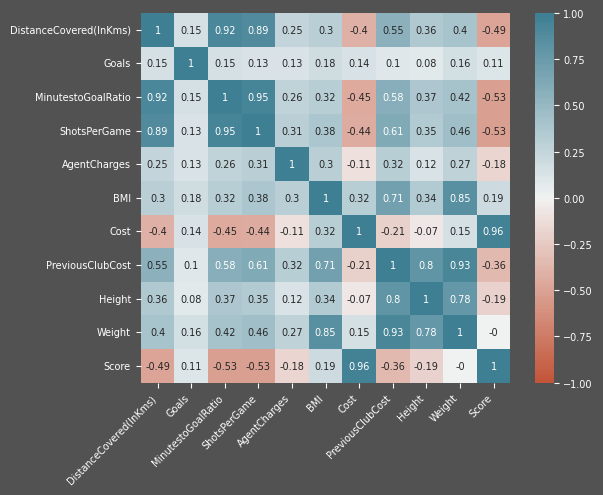

In [30]:
plt.figure(figsize=(14, 8))
fig, ax = plt.subplots()
ax.set_facecolor("#525252")
fig.set_facecolor("#525252")
res = sns.heatmap(
    soccer_df.corr(numeric_only=True).round(2),
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True, annot_kws={"size": 7}
)
res.set_xticklabels(
    res.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=7)
plt.show()

1. Distance Covered has high correlation with Minutes to goal Ratio and Shots Per Game
2. Minutes to goal ratio has high correlation with Shots per Game
3. BMI has high correlation with Weight and Previous Club Cost
4. Previous Club Cost has high correlation with Height and Weight
5. Height has high correlation with Weight

* There is some correlation with or between some other features as well, but for now the above mentioned seem to be higher compared to the ones not listed above.

##### <font color=#4472C4>1. Also looks like Height, Weight, BMI and Agent Score, have very weak correlation with Score. We can remove these.</font>

##### <font color=#BF8F00>1. For multi colinearity we can take a look at VIF Values along with their p-values</font>
##### VIF - Variance Inflation Factor, evaluates the correlation between independent variables. It determines the strength of the correlation between independent variables. We make a prediction and then use R-squared to determine the VIF. VIF Starts with 1 and means no correlation. Values of 5-10 or higher represent very high correlation. If a feature A is being explained well by some other features, this would mean it will have a HIGH VIF. 
$$VIF = \frac{1}{1-R^2}$$ 
##### If A is being explained by some of the other feature variables, this would mean that the R-squared value is pretty high, which would make the denominator, very low. This, in turn, would make the VIF value high.
##### P-Values - Very low p-values indicate they make significant contribution in making the prediction.
##### R-Squared - A very high R-Squared value could mean that the model covers a lot of variance in the training set and could be a good fit. However more analysis may be required for evaluating model-fit.
##### F-Statistic - If the probability of F-Statistic is very low, it means model-fit is statistically significant and that the explained variance by R-Squared is not by chance.
